In [96]:
s = pathlib.Path("")
if str(s):
    print("Yes")

Yes


'.'

In [63]:
import librosa # for mel-spectrogram estimation
import soundfile # for opening .flac audio
from matplotlib import pyplot as plt
import numpy as np

In [64]:
import pytorch_tools as pt
import pathlib
import yaml

In [65]:
!ls

configs     examples		 Makefile   src       train.py
data	    Goznak_ML_Tasks.zip  models     task1.py
Demo.ipynb  logs		 README.md  test.py


In [67]:
root = pathlib.Path(".")
clean_files = sorted((root / 'examples').glob('*.flac'))
noisy_files = sorted((root / 'examples').glob('*noisy*'))

classification_configs = sorted((root / 'logs').glob('*classification*'))
denoising_configs = sorted((root / 'logs').glob('*denoising*'))
denoising_configs
# classification_configs, denoising_configs
# list((root / 'logs').glob('*'))

[PosixPath('logs/denoising_finetune_1024'),
 PosixPath('logs/denoising_finetune_1024-1'),
 PosixPath('logs/denoising_finetune_768'),
 PosixPath('logs/denoising_finetune_768-1'),
 PosixPath('logs/denoising_finetune_768_mse'),
 PosixPath('logs/denoising_unet_resnet50'),
 PosixPath('logs/denoising_unet_seresnet50'),
 PosixPath('logs/denoising_unet_seresnet50_512'),
 PosixPath('logs/denoising_unet_seresnet50_512_ema'),
 PosixPath('logs/denoising_unet_seresnet50_512_ema999'),
 PosixPath('logs/denoising_unet_seresnet50_long')]

In [5]:
# if task == "classification":
#     model = pt.models.__dict__[hparams.arch](num_classes=1, **hparams.model_params).cuda()
# else:
#     model = MODEL_FROM_NAME[hparams.segm_arch](hparams.arch, **hparams.model_params).cuda()

In [6]:
import torch
from src.datasets import get_aug
from src.utils import MODEL_FROM_NAME

In [7]:
import albumentations as albu
import albumentations.pytorch as albu_pt

In [8]:
# resize = albu.PadIfNeeded()


N_FFT = 96 # Image height
size = 141

NORM_TO_TENSOR = albu.Compose([
    # albu.Normalize(mean=MEAN, std=STD),  # No normalization for now
    albu_pt.ToTensorV2()])

CROP_AUG = albu.Compose([
    # albu.PadIfNeeded(min_height=None, min_width=size, pad_height_divisor=32), 
    albu.PadIfNeeded(N_FFT, size, border_mode=0), 
    albu.RandomCrop(N_FFT, size),
])


VAL_AUG = albu.Compose([
    CROP_AUG,
    NORM_TO_TENSOR
])

VAL_AUG

Compose([
  Compose([
    PadIfNeeded(always_apply=False, p=1.0, min_height=96, min_width=141, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=None, mask_value=None),
    RandomCrop(always_apply=False, p=1.0, height=96, width=141),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  Compose([
    ToTensorV2(always_apply=True, p=1.0),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [59]:
ones = np.ones((1, 80, size))
print(ones.shape)

pad = albu.PadIfNeeded(96, size, border_mode=0)
padded = pad(image=ones)["image"]
print(padded.shape)

(1, 80, 141)
(96, 141, 141)


In [62]:
pad

PadIfNeeded(always_apply=False, p=1.0, min_height=96, min_width=141, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=None, mask_value=None)

In [50]:
ones = np.ones((1, N_FFT, size))
print(ones.shape)
ones_transformed = VAL_AUG(image=ones)["image"]
print(ones_transformed.shape)

(1, 96, 141)
torch.Size([141, 96, 141])


In [ ]:
ones = np.ones()

In [20]:
# Read and get melspectogram
noisy_audio, framerate = soundfile.read(noisy_files[0])
noisy_mel = 1 + np.log(
    1.e-12 + librosa.feature.melspectrogram(
        noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)
).T / 10.

logs/denoising_finetune_768_mse
(741, 80)
768 741
torch.Size([1, 3, 96, 768]) torch.float32 cuda:0
Noisy tensor(-0.4583, device='cuda:0') tensor(1.4791, device='cuda:0') tensor(0.2503, device='cuda:0')


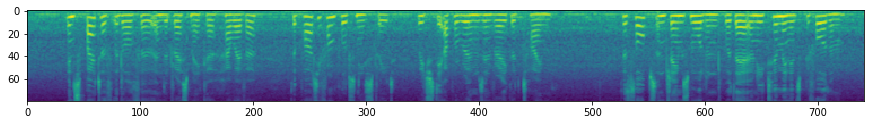

Model loaded succesfully.
Clean shape torch.Size([80, 741])
Clean tensor(-0.6075, device='cuda:0') tensor(1.5844, device='cuda:0') tensor(0.1650, device='cuda:0')
(741, 80) torch.Size([80, 741])


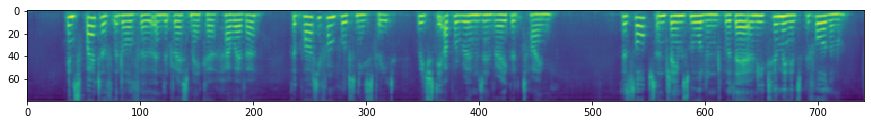

In [92]:
@torch.no_grad()
def denoise_audio(audio_file, config_path):
    print(config_path)
    # Read and get melspectogram
    noisy_audio, framerate = soundfile.read(audio_file)
    noisy_mel = 1 + np.log(
        1.e-12 + librosa.feature.melspectrogram(
            noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)
    ).T / 10.
    print(noisy_mel.shape)
    # Prepare for inference
    length = (noisy_mel.shape[0] + 31) // 32 * 32
    print(length, noisy_mel.shape[0])
    noisy_image = np.repeat(noisy_mel[np.newaxis, :, :], 3, axis=0)
#     transform = get_aug('val', size=length)(image=noisy_image.T, mask=)
    noisy_image = get_aug('val', size=length)(image=noisy_image.T)["image"].unsqueeze(0).cuda()
    print(noisy_image.shape, noisy_image.dtype, noisy_image.device)
    print("Noisy", noisy_image.min(), noisy_image.max(), noisy_image.mean())

    plt.figure(figsize=(15, 10))
    plt.imshow(noisy_mel.T)
    plt.show()
    # Load model
    assert config_path.exists()
    hparams = {}
    with open(config_path / 'config.yaml', "r") as file:
        hparams = yaml.load(file)

    
    model = MODEL_FROM_NAME[hparams['segm_arch']](hparams['arch'], **hparams['model_params']).cuda().eval()
    
    checkpoint = torch.load(config_path / "model.chpn")
    model.load_state_dict(checkpoint["state_dict"])
    model = model.cuda().eval()
    print("Model loaded succesfully.")
    
#     model.eval()
    clean_image = model(noisy_image).squeeze()#[:80, :noisy_mel.shape[0]]
    
    # Crop to original size
    w_pad_left = int((length - noisy_mel.shape[0]) / 2.0)
    w_pad_right = length - noisy_mel.shape[0] - w_pad_left
    clean_image = clean_image[8: -8, w_pad_left: -w_pad_right]
    print("Clean shape", clean_image.shape)
    print("Clean", clean_image.min(), clean_image.max(), clean_image.mean())
    plt.figure(figsize=(15, 10))
    plt.imshow(clean_image.cpu().numpy())
    print(noisy_mel.shape, clean_image.shape)
    

denoised = denoise_audio(noisy_files[0], denoising_configs[4])


# h_pad_top = int((self.min_height - rows) / 2.0)
# h_pad_bottom = self.min_height - rows - h_pad_top

# w_pad_left = int((self.min_width - cols) / 2.0)
# w_pad_right = self.min_width - cols - w_pad_left

In [91]:
pathlib.Path("/tmp/text/file.npy").name

'file.npy'

(741, 80)


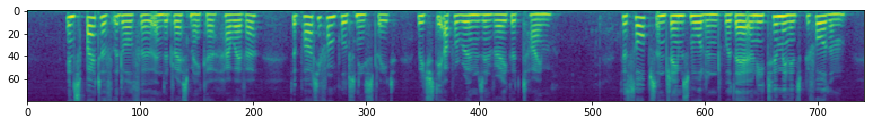

In [83]:
# normalized log-mel-spectrogram of clean and noisy audios

clean_audio, framerate = soundfile.read(clean_files[0])
clean_mel = 1 + np.log(
    1.e-12 + librosa.feature.melspectrogram(
        clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)
).T / 10.
plt.figure(figsize=(15, 10))
print(clean_mel.shape)
plt.imshow(clean_mel.T)


In [49]:
t = torch.rand(32, 3, 128, 130)#.mean(dim=[1, 2, 3])
# torch.rand(32, 3, 128, 130).max(dim=128).values.shape
tt = torch.rand(32, 3, 128, 130)
torch.abs(t - tt)
# torch.min(t)
# torch.mean()

torch.Size([32, 3, 128, 130])

In [43]:
torch.max()

AttributeError: module 'torch' has no attribute 'amax'

In [24]:
(741 + 31) // 32 * 32

768

(741, 80)
torch.Size([1, 3, 96, 736]) torch.float32 cuda:0
torch.Size([96, 736])


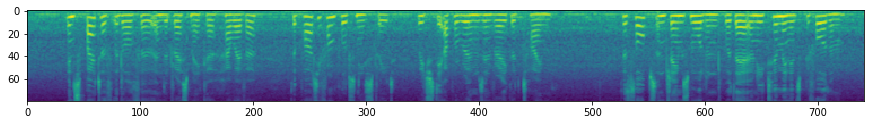

In [39]:
d = {'a': 2, 'b': 3}

TypeError: vars() argument must have __dict__ attribute

In [10]:
clean_audio, framerate = soundfile.read(clean_files[IDX])
noisy_audio, framerate = soundfile.read(noisy_files[IDX])

In [4]:
# normalized log-mel-spectrogram of clean and noisy audios
clean_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.
noisy_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.

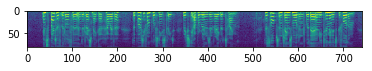

In [5]:
plt.imshow(clean_mel.T)

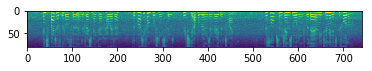

In [6]:
plt.imshow(noisy_mel.T)

In [1]:
torch.tensor(clean)

NameError: name 'torch' is not defined

In [2]:
import albumentations

In [3]:
albumentations.__version__

'0.4.5'

In [ ]:
@torch.no_grad()
def denoise_audio(audio_file, config_path):
    # Read and get melspectogram
    noisy_audio, framerate = soundfile.read(audio_file)
    noisy_mel = 1 + np.log(
        1.e-12 + librosa.feature.melspectrogram(
            noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)
    ).T / 10.
    print(noisy_mel.shape)
    # Prepare for inference
    length = (noisy_mel.shape[0] + 31) // 32 * 32
#     length = 1536
    noisy_image = np.repeat(noisy_mel[np.newaxis, :, :], 3, axis=0)
#     transform = get_aug('val', size=length)(image=noisy_image.T, mask=)
    noisy_image = get_aug('val', size=length)(image=noisy_image.T)["image"].unsqueeze(0).cuda()
    print(noisy_image.shape, noisy_image.dtype, noisy_image.device)
    print("Noisy", noisy_image.min(), noisy_image.max(), noisy_image.mean())

    plt.figure(figsize=(15, 10))
    plt.imshow(noisy_mel.T)
    # Load model
    assert config_path.exists()
    hparams = {}
    with open(config_path / 'config.yaml', "r") as file:
        hparams = yaml.load(file)

    model = MODEL_FROM_NAME[hparams['segm_arch']](hparams['arch'], **hparams['model_params']).cuda().eval()
#     model.eval()
    clean_image = model(noisy_image).squeeze()#[:80, :noisy_mel.shape[0]]
    print(clean_image.shape)
    print("Clean", clean_image.min(), clean_image.max(), clean_image.mean())
    plt.imshow(clean_image.cpu().numpy())
    
    
    

denoise_audio(noisy_files[0], denoising_configs[0])
    
    

In [100]:
import torch.nn as nn

In [124]:
class CRCED(torch.nn.modules.Module):
    def __init__(
        self,
        in_channels=1,
        n_fft=80,
        n_segments=8,
        channels=[18, 30, 8],
        filters=[9, 5, 9],
        n_layers=5,
        norm_name='abn',
        norm_act='relu',
    ):
        super().__init__()
        
        self.n_fft = n_fft
        self.n_segments = n_segments
        self.norm_act = norm_act
        self.norm_layer = pt.modules.bn_from_name(norm_name)
        self.n_layers = n_layers
        self.in_channels = in_channels
        
        self.blocks = []
        self.first = True
        for _ in range(n_layers):
            self.blocks.append(self._make_block(channels, filters))
            
        self.features = nn.Sequential(*self.blocks)
    
        self.last_conv = nn.Conv2d(
            self.in_channels,
            1,
            kernel_size=(1, 1),
            padding=0,
        )

    def forward(self, x):
        """
        Args:
            x: Batch of melspectograms with shape (N, 3, N_FFT, N_SEGMENTS)
        Returns:
            denoised segment
        """
        print(x.shape)
#         for i in range(self.n_layers):
#             x = self.blocks[i](x)
#             print(x.shape)
        x = self.features(x)
        x = self.last_conv(x)
        print(x.shape)
        return x
    
    def _make_block(self, channels, filters):
        layers = []
        for c, f in zip(channels, filters):
            # Shrink along time axis
            if self.first:
                conv2d = nn.Conv2d(self.in_channels, c, kernel_size=(f, self.n_segments), padding=(f // 2, 0))
                self.first = False
            else:
                conv2d = nn.Conv2d(self.in_channels, c, kernel_size=(f, 1), padding=(f // 2, 0))
            layers += [conv2d, self.norm_layer(c, activation=self.norm_act)]
            self.in_channels = c
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                # nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
                
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, self.norm_layer(v, activation=self.norm_act)]
                in_channels = v

In [133]:
mock = torch.rand(32, 1, 80, 128)

model = CRCED(n_fft=80, n_segments=8, norm_act='leaky_relu', )
output = model(mock)
print(output.shape)

torch.Size([32, 1, 80, 128])
torch.Size([32, 1, 80, 121])
torch.Size([32, 1, 80, 121])


In [132]:
# model.parameters

In [130]:
pt.utils.misc.count_parameters(model)[0]

31629